# 推荐系统

# 4. 隐语义模型

## 4.1 基本原理

LFM(Latent Factor Model)隐语义模型是最近几年推荐系统领域最为热门的研究话题，它的核心思想是通过隐含特征(Latent Factor)联系用户兴趣和物品。那这种模型跟ItemCF或UserCF有什么不同呢？这里可以做一个对比：
+ 对于UserCF，我们可以先计算和目标用户兴趣相似的用户，之后再根据计算出来的用户喜欢的物品给目标用户推荐物品。
+ 而ItemCF，我们可以根据目标用户喜欢的物品，寻找和这些物品相似的物品，再推荐给用户。
+ 还有一种方法，先对所有的物品进行分类，再根据用户的兴趣分类给用户推荐该分类中的物品，LFM就是用来实现这种方法。

这个基于兴趣分类的方法大概需要解决3个问题。
+ 如何给物品进行分类？
+ 如何确定用户对哪些类的物品感兴趣，以及感兴趣的程度？
+ 对于一个给定的类，选择哪些属于这个类的物品推荐给用户，以及如何确定这些物品在一个类中的权重？

### 4.1.1 物品分类

对于第一个问题的简单解决方案是找编辑给物品分类。以图书为例，每本书出版时，编辑都会给书一个分类。为了给图书分类，出版界普遍遵循中国图书分类法。但是，即使有很系统的分类体系，编辑给出的分类仍然具有以下缺点：
+ 编辑的意见不能代表各种用户的意见。比如，对于《具体数学》应该属于什么分类，有人认为应该属于数学，有些人认为应该属于计算机。从内容看，这本书是关于数学的，但从用户看，这本书的读大部分是做计算机出身的。编辑的分类大部分是从书的内容出发，而不是从书的读者群出发。
+ 编辑很难控制分类的粒度。我们知道分类是有不同粒度的，《数据挖掘导论》在粗粒度的分类中可能属于计算机技术，但在细粒度的分类中可能属于数据挖掘。对于不同的用户，我们可能需要不同的粒度。比如对于一位初学者，我们粗粒度地给他做推荐就可以了，而对于一名资深研究人员，我们就需要深入到他的很细分的领域给他做个性化推荐。
+ 编辑很难给一个物品多个分类。有的书不仅属于一个类，而是可能属于很多的类。
+ 编辑很难给出多维度的分类。我们知道，分类是可以有很多维度的，比如按照作者分类、按照译者分类、按照出版社分类。比如不同的用户看《具体数学》原因可能不同，有些人是因为它是数学方面的书所以才看的，而有些人是因为它是大师Knuth的著作所以才去看，因此在不同人的眼中这本书属于不同的分类。
+ 编辑很难决定一个物品在某一个分类中的权重。比如编辑可以很容易地决定《数据挖掘导论》属于数据挖掘类图书，但这本书在这类书中的定位是什么样的，编辑就很难给出一个准确的数字来表示。

为了解决上面的问题，研究人员提出：为什么我们不从数据出发，自动地找到那些类，然后进行个性化推荐？于是，隐含语义分析技术（latent variable analysis）出现了。隐含语义分析技术因为采取基于用户行为统计的自动聚类，较好地解决了上面提出的5个问题。

最简单的办法是直接矩阵分解：

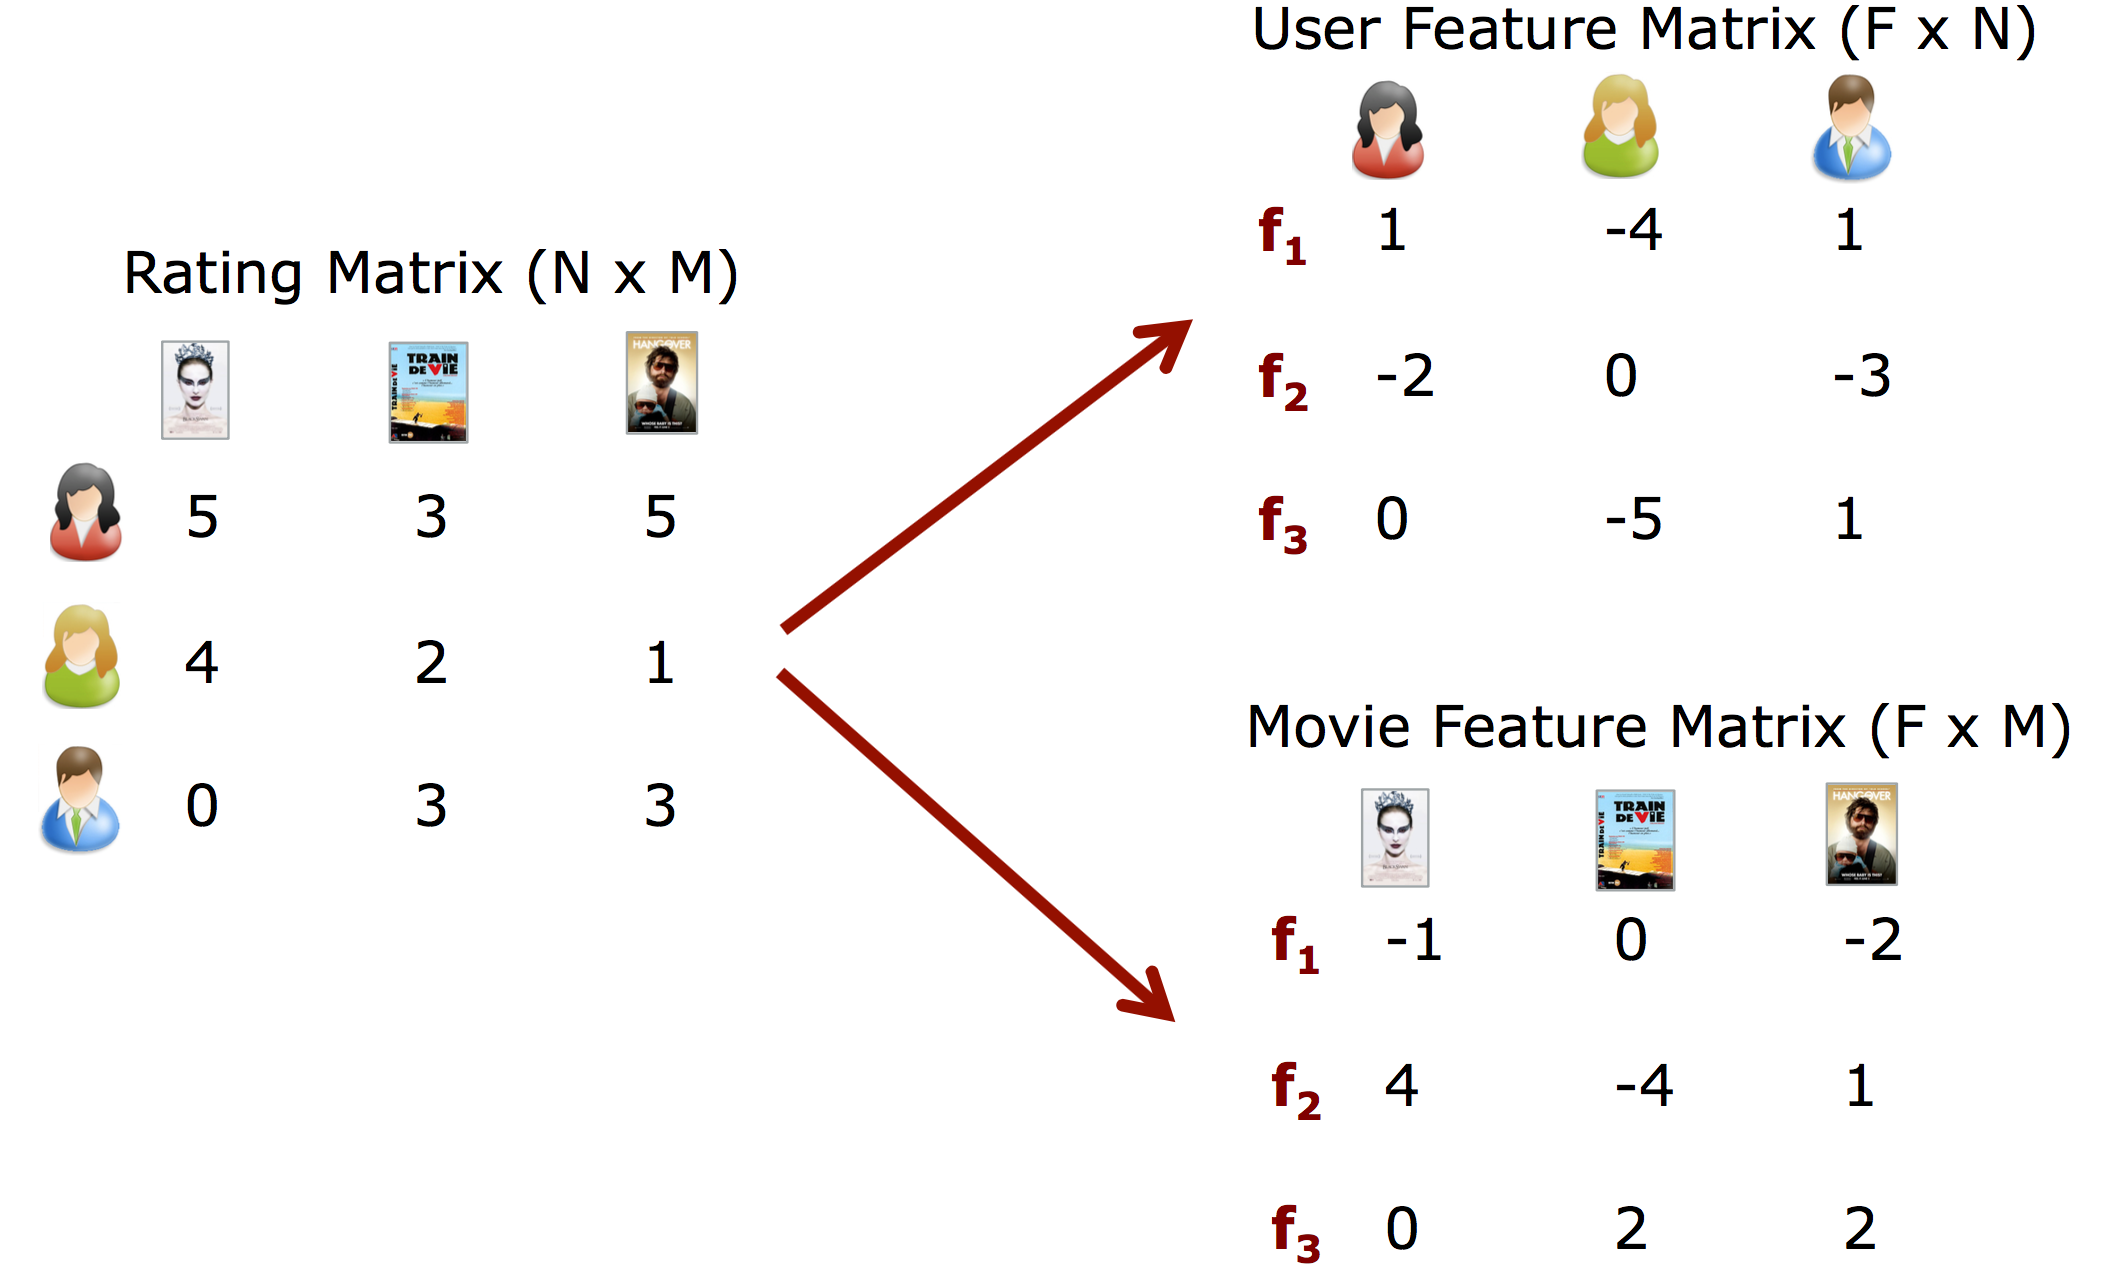

我们假定隐藏因子F的个数小于user和item数。因为如果每个user都关联一个独立的隐藏因子，那就没法做预测了。

### 4.1.2 用户对物品感兴趣程度

LFM通过如下公式计算用户u对物品i的兴趣：$$Preference(u.i)=r_{ui}=p_u^Tq_i=\sum_{k=1}^{F}p_{uk}q_{ki}$$这个公式中 $p_{uk}$和$q_{ki}$是模型的参数，其中$p_{uk}$度量了用户u的兴趣和第k个隐类的关系，而$q_{ki}$度量了第k个隐类和物品i之间的关系。那么，下面的问题就是如何计算这两个参数。要计算这两个参数，需要一个训练集，对于每个用户u，训练集里都包含了用户u喜欢的物品和不感兴趣的物品，通过学习这个数据集，就可以获得上面的模
型参数。

推荐系统的用户行为分为显性反馈和隐性反馈。LFM在显性反馈数据（也就是评分数据）上解决评分预测问题并达到了很好的精度。不过这里主要讨论的是隐性反馈数据集，这种数据集的特点是只有正样本（用户喜欢什么物品），而没有负样本（用户对什么物品不感兴趣）。

通过2011年的KDD Cup的Yahoo! Music推荐系统比赛，我们发现对**负样本采样**时应该遵循以下原则。
+ 对每个用户，要保证正负样本的平衡（数目相似）。
+ 对每个用户采样负样本时，要选取那些很热门，而用户却没有行为的物品。

经过采样，可以得到一个用户—物品集K={(u,i)}，其中如果(u, i)是正样本，则有$r_{ui}=1$ ，否则有$r_{ui}=0$ 。然后，需要优化如下的损失函数来找到最合适的参数p和q：$$C=\sum_{u,i∈K}(r_{ui}-\hat{r}_{ui})^2+λ(||p_u||^2+||q_i||^2)$$这里，$λ(||p_u||^2+||q_i||^2)$是用来防止过拟合的正则化项，λ可以通过实验获得。要最小化上面的损失函数，可以利用一种称为随机梯度下降法的算法。

上面定义的损失函数里有两组参数puk和qik，随机梯度下降法需要首先对它们分别求偏导数，可以得到：$$\dfrac{∂C}{∂p_{uk}}=-2q_{ik}+2λp_{uk}$$$$\dfrac{∂C}{∂q_{uk}}=-2p_{uk}+2λp_{ik}$$
然后，根据随机梯度下降法，需要将参数沿着最速下降方向向前推进，因此可以得到如下递推公式：$$p_uk=p_{uk}+α(q_{ik}-λp_{uk})$$$$q_uk=q_{ik}+α(p_{uk}-λq_{ik})$$
其中，α是学习速率（learning rate），它的选取需要通过反复实验获得。

## 4.2 代码实现

确定数据集

In [29]:
import pandas as pd
import numpy as np
critics={'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
 'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5, 
 'The Night Listener': 3.0},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5, 
 'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0, 
 'You, Me and Dupree': 3.5}, 
'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
 'Superman Returns': 3.5, 'The Night Listener': 4.0},
'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
 'The Night Listener': 4.5, 'Superman Returns': 4.0, 
 'You, Me and Dupree': 2.5},
'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0, 
 'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
 'You, Me and Dupree': 2.0}, 
'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
 'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
'Toby': {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}}
criticsdf = pd.DataFrame(critics).stack()
criticsdf=pd.DataFrame([criticsdf.index.get_level_values(1),criticsdf.index.get_level_values(0),criticsdf.values],index=['user','movies','rating']).T
criticsdf

,user,movies,rating
0,Claudia Puig,Just My Luck,3
1,Gene Seymour,Just My Luck,1.5
2,Lisa Rose,Just My Luck,3
3,Mick LaSalle,Just My Luck,2
4,Gene Seymour,Lady in the Water,3
5,Jack Matthews,Lady in the Water,3
6,Lisa Rose,Lady in the Water,2.5
7,Michael Phillips,Lady in the Water,2.5
8,Mick LaSalle,Lady in the Water,3
9,Claudia Puig,Snakes on a Plane,3.5


### 4.2.1 正负反馈的item

首先我们需要计算包含用户喜欢与不喜欢物品的数据集，采用不计算评分的隐反馈方式，只要用户评过分均认为用户对该物品有兴趣，而没有评分则可能没兴趣。用户正反馈数据:

In [30]:
def getUserPositiveItem(frame, user):
    '''
    获取用户正反馈物品：用户评分过的物品
    :param frame: 数据集
    :param user: 用户
    :return: 正反馈物品
    '''    
    columns = list(frame.columns)
    series = frame[frame[columns[0]] == user][columns[1]]
    positiveItemList = list(series.values)
    return positiveItemList
getUserPositiveItem(criticsdf,'Toby')

['Snakes on a Plane', 'Superman Returns', 'You, Me and Dupree']

用户负反馈数据，根据用户无评分物品进行推荐，越热门的物品用户却没有进行过评分，认为用户越有可能对这物品没有兴趣

In [31]:
def getUserNegativeItem(frame, user):  
    ''''' 
    获取用户负反馈物品：热门但是用户没有进行过评分 与正反馈数量相等 
    :param frame: 数据集 
    :param user:用户
    :return: 负反馈物品 
    '''      
    columns = list(frame.columns)
    userItemlist = list(set(frame[frame[columns[0]] == user][columns[1]])) #用户评分过的物品  
    otherItemList = [item for item in set(frame[columns[1]].values) if item not in userItemlist] #用户没有评分的物品  
    itemCount = [len(frame[frame[columns[1]] == item][columns[0]]) for item in otherItemList]      #物品热门程度  
    series = pd.Series(itemCount, index=otherItemList)  
    series = series.sort_values(ascending=False)[:len(userItemlist)]                            #获取正反馈物品数量的负反馈物品  
    negativeItemList = list(series.index)  
    return negativeItemList  
getUserNegativeItem(criticsdf,'Toby')

['The Night Listener', 'Lady in the Water', 'Just My Luck']

### 3.2.2 初始化数据集

初始化用户正负反馈物品,正反馈标签为1,负反馈为0

In [32]:
def initUserItem(frame, userList):
    '''
    :param frame: ratings数据
    :param userList: 用户集
    :return: 正负反馈物品字典
    '''
    userItem={}
    for user in userList:
        positiveItem = getUserPositiveItem(frame, user)
        negativeItem = getUserNegativeItem(frame, user)
        itemDict = {}
        for item in positiveItem: itemDict[item] = 1
        for item in negativeItem: itemDict[item] = 0
        userItem[user]=itemDict
    return userItem
initUserItem(criticsdf,set(criticsdf['user']))

{'Claudia Puig': {'Just My Luck': 1,
  'Lady in the Water': 0,
  'Snakes on a Plane': 1,
  'Superman Returns': 1,
  'The Night Listener': 1,
  'You, Me and Dupree': 1},
 'Gene Seymour': {'Just My Luck': 1,
  'Lady in the Water': 1,
  'Snakes on a Plane': 1,
  'Superman Returns': 1,
  'The Night Listener': 1,
  'You, Me and Dupree': 1},
 'Jack Matthews': {'Just My Luck': 0,
  'Lady in the Water': 1,
  'Snakes on a Plane': 1,
  'Superman Returns': 1,
  'The Night Listener': 1,
  'You, Me and Dupree': 1},
 'Lisa Rose': {'Just My Luck': 1,
  'Lady in the Water': 1,
  'Snakes on a Plane': 1,
  'Superman Returns': 1,
  'The Night Listener': 1,
  'You, Me and Dupree': 1},
 'Michael Phillips': {'Just My Luck': 0,
  'Lady in the Water': 1,
  'Snakes on a Plane': 1,
  'Superman Returns': 1,
  'The Night Listener': 1,
  'You, Me and Dupree': 0},
 'Mick LaSalle': {'Just My Luck': 1,
  'Lady in the Water': 1,
  'Snakes on a Plane': 1,
  'Superman Returns': 1,
  'The Night Listener': 1,
  'You, Me a

初始化参数q,p矩阵, 这里我们采用随机初始化的方式，将p和q取值在[0,1]之间

In [33]:
def initPara(userList, itemList, classCount):
    '''
    :param userList:用户集
    :param itemList:物品集
    :param classCount: 隐类数量
    :return: 参数p,q
    '''
    arrayp = np.random.rand(len(userList), classCount)
    arrayq = np.random.rand(classCount, len(itemList))
    p = pd.DataFrame(arrayp, columns=range(0,classCount), index=userList)
    q = pd.DataFrame(arrayq, columns=itemList, index=range(0,classCount))
    return p,q
initPara(set(criticsdf['user']),set(criticsdf['movies']),classCount=3)

(                         0         1         2
 Michael Phillips  0.280069  0.129800  0.367130
 Mick LaSalle      0.716528  0.992088  0.842967
 Gene Seymour      0.027717  0.251132  0.208548
 Claudia Puig      0.528001  0.111643  0.720166
 Lisa Rose         0.332606  0.767465  0.662097
 Jack Matthews     0.935804  0.838451  0.517181
 Toby              0.154956  0.389750  0.241037,
    Lady in the Water  Just My Luck  You, Me and Dupree  Snakes on a Plane  \
 0           0.655240      0.076027            0.320356           0.141127   
 1           0.386934      0.091283            0.793258           0.937764   
 2           0.031649      0.905714            0.898889           0.442174   
 
    Superman Returns  The Night Listener  
 0          0.934391            0.025923  
 1          0.381205            0.843723  
 2          0.151936            0.597316  )

初始化模型：参数p,q,样本数据

In [34]:
def initModel(frame, classCount):
    '''
    :param frame: 源数据
    :param classCount: 隐类数量
    :return:
    '''
    columns = list(frame.columns)    
    userList = list(set(frame[columns[0]].values))
    itemList = list(set(frame[columns[1]].values))
    p, q = initPara(userList, itemList, classCount)
    userItem = initUserItem(frame,userList)
    return p, q, userItem
p,q,userItem=initModel(criticsdf,3)
userItem

{'Claudia Puig': {'Just My Luck': 1,
  'Lady in the Water': 0,
  'Snakes on a Plane': 1,
  'Superman Returns': 1,
  'The Night Listener': 1,
  'You, Me and Dupree': 1},
 'Gene Seymour': {'Just My Luck': 1,
  'Lady in the Water': 1,
  'Snakes on a Plane': 1,
  'Superman Returns': 1,
  'The Night Listener': 1,
  'You, Me and Dupree': 1},
 'Jack Matthews': {'Just My Luck': 0,
  'Lady in the Water': 1,
  'Snakes on a Plane': 1,
  'Superman Returns': 1,
  'The Night Listener': 1,
  'You, Me and Dupree': 1},
 'Lisa Rose': {'Just My Luck': 1,
  'Lady in the Water': 1,
  'Snakes on a Plane': 1,
  'Superman Returns': 1,
  'The Night Listener': 1,
  'You, Me and Dupree': 1},
 'Michael Phillips': {'Just My Luck': 0,
  'Lady in the Water': 1,
  'Snakes on a Plane': 1,
  'Superman Returns': 1,
  'The Night Listener': 1,
  'You, Me and Dupree': 0},
 'Mick LaSalle': {'Just My Luck': 1,
  'Lady in the Water': 1,
  'Snakes on a Plane': 1,
  'Superman Returns': 1,
  'The Night Listener': 1,
  'You, Me a

### 3.2.3 隐语义模型

定义函数,计算用户对物品的兴趣

In [35]:
from math import exp
def sigmod(x):
    '''
    单位阶跃函数,将兴趣度限定在[0,1]范围内
    :param x: 兴趣度
    :return: 兴趣度
    '''
    y = 1.0/(1+exp(-x))
    return y


def lfmPredict(p, q, user,item):
    '''
    利用参数p,q预测目标用户对目标物品的兴趣度
    :param p: 用户兴趣和隐类的关系
    :param q: 隐类和物品的关系
    :param user: 目标用户
    :param item: 目标物品
    :return: 预测兴趣度
    '''
    p = np.mat(p.loc[user].values)
    q = np.mat(q.loc[:,item].values).T
    r = (p * q).sum()
    r = sigmod(r)
    return r

lfmPredict(p,q,'Toby','You, Me and Dupree')

0.6537095443850449

用梯度下降法计算较优的隐语义模型计算参数p,q

In [36]:
def latenFactorModel(frame, classCount, iterCount, alpha, lamda):
    '''
    :param frame: 源数据
    :param classCount: 隐类数量
    :param iterCount: 迭代次数
    :param alpha: 步长，学习率
    :param lamda: 正则化参数
    :return: 参数p,q
    '''
    p, q, userItem = initModel(frame, classCount)
    for step in range(0, iterCount):
        for user in userItem:
            for item,rui in userItem[user].items():
                eui = rui - lfmPredict(p=p, q=q, user=user, item=item)
                for f in range(0, classCount):
                    print('step %d user %s class %d' % (step, user, f))
                    p[f][user] += alpha * (eui * q[item][f] - lamda * p[f][user])
                    q[item][f] += alpha * (eui * p[f][user] - lamda * q[item][f])
        alpha *= 0.9
    return p, q
p,q=latenFactorModel(criticsdf, 3, 10, 0.02, 0.01)

step 0 user Michael Phillips class 0
step 0 user Michael Phillips class 1
step 0 user Michael Phillips class 2
step 0 user Michael Phillips class 0
step 0 user Michael Phillips class 1
step 0 user Michael Phillips class 2
step 0 user Michael Phillips class 0
step 0 user Michael Phillips class 1
step 0 user Michael Phillips class 2
step 0 user Michael Phillips class 0
step 0 user Michael Phillips class 1
step 0 user Michael Phillips class 2
step 0 user Michael Phillips class 0
step 0 user Michael Phillips class 1
step 0 user Michael Phillips class 2
step 0 user Michael Phillips class 0
step 0 user Michael Phillips class 1
step 0 user Michael Phillips class 2
step 0 user Mick LaSalle class 0
step 0 user Mick LaSalle class 1
step 0 user Mick LaSalle class 2
step 0 user Mick LaSalle class 0
step 0 user Mick LaSalle class 1
step 0 user Mick LaSalle class 2
step 0 user Mick LaSalle class 0
step 0 user Mick LaSalle class 1
step 0 user Mick LaSalle class 2
step 0 user Mick LaSalle class 0
step

step 4 user Jack Matthews class 1
step 4 user Jack Matthews class 2
step 4 user Jack Matthews class 0
step 4 user Jack Matthews class 1
step 4 user Jack Matthews class 2
step 4 user Jack Matthews class 0
step 4 user Jack Matthews class 1
step 4 user Jack Matthews class 2
step 4 user Jack Matthews class 0
step 4 user Jack Matthews class 1
step 4 user Jack Matthews class 2
step 4 user Jack Matthews class 0
step 4 user Jack Matthews class 1
step 4 user Jack Matthews class 2
step 4 user Toby class 0
step 4 user Toby class 1
step 4 user Toby class 2
step 4 user Toby class 0
step 4 user Toby class 1
step 4 user Toby class 2
step 4 user Toby class 0
step 4 user Toby class 1
step 4 user Toby class 2
step 4 user Toby class 0
step 4 user Toby class 1
step 4 user Toby class 2
step 4 user Toby class 0
step 4 user Toby class 1
step 4 user Toby class 2
step 4 user Toby class 0
step 4 user Toby class 1
step 4 user Toby class 2
step 5 user Michael Phillips class 0
step 5 user Michael Phillips class 1


step 9 user Gene Seymour class 2
step 9 user Gene Seymour class 0
step 9 user Gene Seymour class 1
step 9 user Gene Seymour class 2
step 9 user Claudia Puig class 0
step 9 user Claudia Puig class 1
step 9 user Claudia Puig class 2
step 9 user Claudia Puig class 0
step 9 user Claudia Puig class 1
step 9 user Claudia Puig class 2
step 9 user Claudia Puig class 0
step 9 user Claudia Puig class 1
step 9 user Claudia Puig class 2
step 9 user Claudia Puig class 0
step 9 user Claudia Puig class 1
step 9 user Claudia Puig class 2
step 9 user Claudia Puig class 0
step 9 user Claudia Puig class 1
step 9 user Claudia Puig class 2
step 9 user Claudia Puig class 0
step 9 user Claudia Puig class 1
step 9 user Claudia Puig class 2
step 9 user Lisa Rose class 0
step 9 user Lisa Rose class 1
step 9 user Lisa Rose class 2
step 9 user Lisa Rose class 0
step 9 user Lisa Rose class 1
step 9 user Lisa Rose class 2
step 9 user Lisa Rose class 0
step 9 user Lisa Rose class 1
step 9 user Lisa Rose class 2
step

### 3.2.4 推荐商品

最后根据计算出来的p和q参数对用户进行物品的推荐

In [37]:
def recommend(frame, user, p, q, TopN=5):
    '''
    推荐TopN个物品给目标用户
    :param frame: 源数据
    :param user: 目标用户
    :param p: 用户兴趣和隐类的关系
    :param q: 隐类和物品的关系
    :param TopN: 推荐数量
    :return: 推荐物品
    '''    
    columns = list(frame.columns) 
    userItemlist = list(set(frame[frame[columns[0]] == user][columns[1]]))
    otherItemList = [item for item in set(frame[columns[1]].values) if item not in userItemlist]
    predictList = [lfmPredict(p, q, user, item) for item in otherItemList]
    series = pd.Series(predictList, index=otherItemList)
    series = series.sort_values(ascending=False)[:TopN]
    return series
recommend(criticsdf, 'Toby', p, q)

Lady in the Water     0.631075
Just My Luck          0.619601
The Night Listener    0.616540
dtype: float64